In [11]:
import torch
from torch import nn
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.ToTensor()])

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [3]:
# how many samples per batch to load
batch_size = 32

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

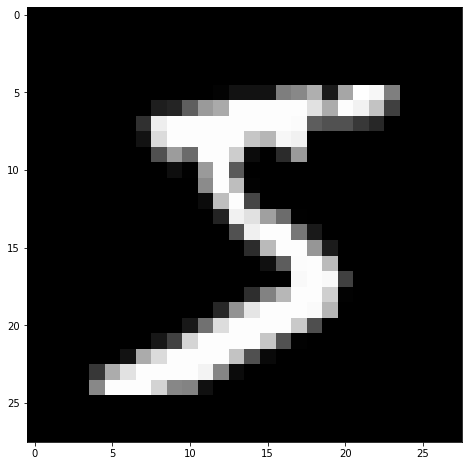

In [5]:
 
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
image = np.squeeze(images[0])

fig = plt.figure(figsize = (8,8)) 
ax = fig.add_subplot(1,1,1)
ax.imshow(image, cmap='gray')

In [8]:
# NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        

    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.fc2(x))
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


In [29]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters())

In [33]:
# number of epochs to train the model

def train(model, criterion, optimizer, train_loader, lr=0.001, n_epochs=3):
    """
    Train given model based on parameters given
    :param model: autoencoder model
    :param criterion: loss function
    :param optimizer: optimizer  function
    :param train_loader: dataloader
    :param lr: learing rate
    :return: max-pooled feature vector
    """
    optimizer.param_groups[0]['lr']
    
    for epoch in range(1, n_epochs+1):

        train_loss = 0.0
        for data in train_loader:
            images, labels = data
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)

        # print avg training statistics 
        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))
    return model

In [34]:
model = train(model, criterion, optimizer, train_loader)

D:\Program\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 3.388276
Epoch: 2 	Training Loss: 3.332612
Epoch: 3 	Training Loss: 3.328295


In [35]:
def save(model, model_name):
    torch.save(model.state_dict(),f"brain\{model_name}.pt")
    
def load_model(model, path):
    return model.load_state_dict(torch.load(path))

In [37]:
save(model,"simple-autoencoder")

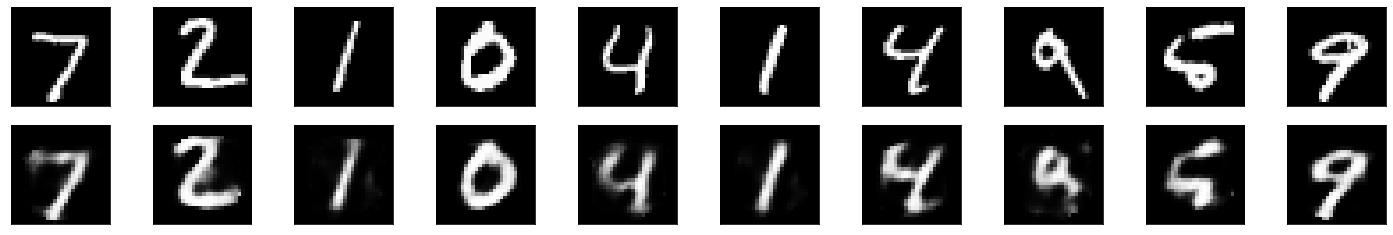

In [13]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)

images = images.numpy()
output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)